# Lab1 Intro
In the retail industry, understanding the Voice of the Customer (VOC) is crucial for gaining insights into customer preferences and pain points. By analyzing and categorizing customer feedback, retailers can improve their products, services, and overall customer experience.

This hands-on workshop guides participants through the process of classifying Voice of Customer (VOC) data using Amazon Titan on Amazon Bedrock.
You will be provided with sample data and will be tasked with classifying customer feedback into categories and generating a summary analysis report.

- First, you will learn how to use Prompt Engineering to classify customer feedback.
- Then, you will explore the concept of embedding techniques and use them to classify customer feedback by semantic comparison.
- After that, you will be provided with additional example data. You will explore the concept of retrieval augmented generation (RAG) and use it to enhance the classification process by dynamically retrieving relevant few-shot examples.
- At the end of the workshop, you will be able to generate a comprehensive analysis report that provides insights into the VOC data and helps retailers improve their products and services.

### A task of developing a VoC Classifier has been assigned to you:
You will be provided with a sample dataset in "data/comments.csv", each record represents a customer comment and its corresponding groundtruth category. You need to write prompt to perform the classification task using the Amazon Titan Model, and then compare the prediction result with the groundtruth and calculate the accuracy.

### Your objectives are:

- Classify each customer feedback comment into 35+ categories
- Provide the reasoning behind each classification
- Summarize each customer comment in a brief description



## 1. Install dependencies

In [66]:
!pip install --upgrade pip
!pip install -q langchain==0.2.16 langchain_aws==0.1.17 pandas==2.2.2 openpyxl==3.1.5 termcolor==2.4.0 python-dotenv==1.0.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 86.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2


## 2. Initialize Bedrock model using LangChain
- First let's see what 'Titan' language models we have in Bedrock

In [67]:
import boto3
import json
import copy
import pandas as pd
from termcolor import colored
# create clients of bedrock
bedrock = boto3.client(service_name='bedrock')
bedrock_runtime = boto3.client(service_name='bedrock-runtime') 
pd.set_option('display.max_rows', None)
results = []

available_models = bedrock.list_foundation_models()
for model in available_models['modelSummaries']:
    if 'Titan' in model['modelName'] and 'TEXT' in model['outputModalities']: # Only select models containing 'Titan' 
        results.append({
            'Model Name': model['modelName'],
            'Model ID': model['modelId'],  # Add Model ID column
            'Provider': model['providerName'],
            'Input Modalities': ', '.join(model['inputModalities']),
            'Output Modalities': ', '.join(model['outputModalities']),
            'Streaming': model.get('responseStreamingSupported', 'N/A'),
            'Status': model['modelLifecycle']['status']
        })

df = pd.DataFrame(results)
display(df)

pd.reset_option('display.max_rows')

,Model Name,Model ID,Provider,Input Modalities,Output Modalities,Streaming,Status
0,Titan Text Large,amazon.titan-tg1-large,Amazon,TEXT,TEXT,True,ACTIVE
1,Titan Text G1 - Premier,amazon.titan-text-premier-v1:0,Amazon,TEXT,TEXT,True,ACTIVE
2,Titan Text G1 - Lite,amazon.titan-text-lite-v1:0:4k,Amazon,TEXT,TEXT,True,ACTIVE
3,Titan Text G1 - Lite,amazon.titan-text-lite-v1,Amazon,TEXT,TEXT,True,ACTIVE
4,Titan Text G1 - Express,amazon.titan-text-express-v1:0:8k,Amazon,TEXT,TEXT,True,ACTIVE
5,Titan Text G1 - Express,amazon.titan-text-express-v1,Amazon,TEXT,TEXT,True,ACTIVE


We employ the Langchain SDK to configure and initiate a test interaction with the Amazon Titan Text Model.
- Import [Langchain](https://www.langchain.com/) SDK to build the application
- Initialize a ChatBedrock object with Amzon Titan Text model, the model id is "amazon.titan-text-premier-v1:0"
- <span style="color: red;">Note: If your workshop is using the us-west-2 region, replace the model_id in the code below with 'amazon.titan-text-express-v1'.</span>

#### Use Olympus

In [70]:
import boto3
import json
from botocore.exceptions import ClientError
import dotenv
import os
dotenv.load_dotenv()

from typing import Any, AsyncIterator, Dict, Iterator, List, Optional

from langchain_core.callbacks import (
    AsyncCallbackManagerForLLMRun,
    CallbackManagerForLLMRun,
)
from langchain_core.language_models import BaseChatModel, SimpleChatModel
from langchain_core.messages import AIMessageChunk, BaseMessage, HumanMessage,AIMessage,SystemMessage
from langchain_core.outputs import ChatGeneration, ChatGenerationChunk, ChatResult
from langchain_core.runnables import run_in_executor
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_core.output_parsers import StrOutputParser,XMLOutputParser
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder,HumanMessagePromptTemplate


class ChatModelOly(BaseChatModel):

    model_name: str
    br_runtime : Any = None
    ak: str = None
    sk: str = None
    region:str = None

    def _generate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> ChatResult:

        if not self.br_runtime:
            if self.ak and self.sk:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime',
                                               region_name = self.region,
                                              aws_access_key_id = self.ak,
                                               aws_secret_access_key = self.sk
            
                                              )

            else:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime')
            
        
        new_messages = []
        system_message = ''
        for msg in messages:
            if isinstance(msg,SystemMessage):
                system_message = msg.content
            elif isinstance(msg,HumanMessage):
                new_messages.append({
                        "role": "user",
                        "content": [ {"text": msg.content}]
                    })
            elif isinstance(msg,AIMessage):
                new_messages.append({
                        "role": "assistant",
                        "content": [ {"text": msg.content}]
                    })

        
        temperature = kwargs.get('temperature',0.5)
        maxTokens = kwargs.get('max_tokens',3000)

        #Base inference parameters to use.
        inference_config = {"temperature": temperature,"maxTokens":maxTokens}


        # Send the message.
        response = self.br_runtime.converse(
            modelId=self.model_name,
            messages=new_messages,
            system=[{"text" : system_message}] if system_message else [],
            inferenceConfig=inference_config
        )
        output_message = response['output']['message']

        message = AIMessage(
            content=output_message['content'][0]['text'],
            additional_kwargs={},  # Used to add additional payload (e.g., function calling request)
            response_metadata={  # Use for response metadata
                **response['usage']
            },
        )
        generation = ChatGeneration(message=message)
        return ChatResult(generations=[generation])


    def _stream(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> Iterator[ChatGenerationChunk]:
        if not self.br_runtime:
            if self.ak and self.sk:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime',
                                               region_name = self.region,
                                              aws_access_key_id = self.ak,
                                               aws_secret_access_key = self.sk
            
                                              )

            else:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime')
            
        
        new_messages = []
        system_message = ''
        for msg in messages:
            if isinstance(msg,SystemMessage):
                system_message = msg.content
            elif isinstance(msg,HumanMessage):
                new_messages.append({
                        "role": "user",
                        "content": [ {"text": msg.content}]
                    })
            elif isinstance(msg,AIMessage):
                new_messages.append({
                        "role": "assistant",
                        "content": [ {"text": msg.content}]
                    })

        
        temperature = kwargs.get('temperature',0.5)
        maxTokens = kwargs.get('max_tokens',3000)

        #Base inference parameters to use.
        inference_config = {"temperature": temperature,"maxTokens":maxTokens}

        # Send the message.
        streaming_response = self.br_runtime.converse_stream(
            modelId=self.model_name,
            messages=new_messages,
            system=[{"text" : system_message}] if system_message else [],
            inferenceConfig=inference_config
        )
        # Extract and print the streamed response text in real-time.
        for event in streaming_response["stream"]:
            if "contentBlockDelta" in event:
                text = event["contentBlockDelta"]["delta"]["text"]
                # print(text, end="")
                chunk = ChatGenerationChunk(message=AIMessageChunk(content=[{"type":"text","text":text}]))

                if run_manager:
                    # This is optional in newer versions of LangChain
                    # The on_llm_new_token will be called automatically
                    run_manager.on_llm_new_token(token, chunk=chunk)

                yield chunk
            if 'metadata' in event:
                metadata = event['metadata']
                # Let's add some other information (e.g., response metadata)
                chunk = ChatGenerationChunk(
                    message=AIMessageChunk(content="", response_metadata={**metadata})
                )
                if run_manager:

                    run_manager.on_llm_new_token(token, chunk=chunk)
                yield chunk

    @property
    def _llm_type(self) -> str:
        """Get the type of language model used by this chat model."""
        return "echoing-chat-model-advanced"

    @property
    def _identifying_params(self) -> Dict[str, Any]:
        """Return a dictionary of identifying parameters.

        This information is used by the LangChain callback system, which
        is used for tracing purposes make it possible to monitor LLMs.
        """
        return {
            "model_name": self.model_name,
        }

llm = ChatModelOly(model_name="amazon.olympus-pro-v1:0",
                     ak=os.environ['ak'],
                     sk=os.environ['sk'],
                    region=os.environ['region']
                    )


#### Use Titan

In [21]:
from langchain_aws import ChatBedrock
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_core.output_parsers import StrOutputParser,XMLOutputParser
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder,HumanMessagePromptTemplate

model_id = "amazon.titan-text-premier-v1:0"
llm = ChatBedrock( model_id=model_id,
                  streaming=False,
                # callbacks=[StreamingStdOutCallbackHandler()],
                model_kwargs=dict(temperature=0.0,maxTokenCount=3072)
                 )

Now, we'll conduct a test run with the Amazon Titan Text Model, tasking it to perform a language translation.

In [71]:
messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
llm.invoke(messages)

AIMessage(content="J'adore la programmation.", response_metadata={'inputTokens': 0, 'outputTokens': 0, 'totalTokens': 0}, id='run-46456365-38f8-4af5-8c4b-bcf417e2e749-0')

## 3. Preparing the Dataset to be classified. 
In this section, we will examine the provided Voice of Customers dataset, explore its contents, and identify all the groundtruth categories it includes.
- The data (Voice of Customers) is subject to experiment usage only

### Load the customer review data

- Load the examples data


From the displayed dataset, we can observe that it consists of two columns: 'comment' and 'groundtruth'. The 'comment' column contains collected customer feedback, while the 'groundtruth' column specifies the categories to which each comment belongs.

In [72]:
comments_filepath = "data/comments_9.csv"
comments = pd.read_csv(comments_filepath)
display(comments)

,comment,groundtruth
0,"After switching to a new operating system, my ...",Charging failure
1,"After 10 months, my phone's battery health has...",Abnormal battery health
2,"Yesterday, the battery health was still 94%. B...",Abnormal battery health
3,The camera quality of my smartphone has been q...,Camera color deviation
4,"The update speed of this phone is really slow,...",Update delay
...,...,...
195,My phone's been acting up for a while now. The...,Unresponsive screen
196,"After the recent software update, my device ha...","Automatic restart, shutdown"
197,Every major software update seems to cause iss...,SIM card not detected
198,"My phone has been getting slower and slower, a...",High storage usage


- List categories values

The printed output displays all the categories contained within this dataset.

In [73]:
category_definition = "data/categories.csv"
categories = pd.read_csv(category_definition)
display(categories['mappings'].values)

array(['Camera lens glare', 'CarPlay connection failure', 'Update delay',
       'Camera dust and dirt', 'Automatic restart, shutdown',
       'High storage usage', 'Poor manufacturing quality',
       'Frame rate drop', 'Camera black screen', 'App crashes',
       'Third-party charger, data cable incompatibility',
       'Screen flickering', 'User interface errors',
       'Abnormal battery health', 'Weak signal', 'Unresponsive screen',
       'Data loss after update', 'Screen color deviation',
       'Widget display failure', 'SIM card not detected', 'Overheating',
       'Charging failure', 'Easily retains fingerprints',
       'Activation failure', 'Face ID malfunction', 'Fast battery drain',
       'Update failure', 'Wi-Fi connection failure', 'Slow update',
       'Third-party app incompatibility', 'Camera color deviation',
       'Slow or failed data migration', 'Others', 'Lag and stuttering',
       'Device freezing'], dtype=object)

## 4. Define system prompt and user prompt template

Below, we have outlined templates for both the system prompt and the user prompt. We will use it to guide the Titan model to perform the classification tasks.

Examing the template, there are a few elements that make this prompt efffective for guiding the Titan model in classifying customer feedback accurately. For both prompt, they clearly defines the role of the model as a professional customer feedback analyst and includes detailed, step-by-step instructions on how the classification should be conducted, the format of the output, the tone to be maintained, and specific guidance on handling ambiguous cases.

In [74]:
system = """You are a professional  customer feedback analyst. Your daily task is to categorize user feedback.
You will be given an input in the form of a JSON array. Each object in the array contains a comment ID and a 'c' field representing the user's comment content.
Your role is to analyze these comments and categorize them appropriately.
Please note:
1. Only output valid XML format data.
2. Do not include any explanations or additional text outside the XML structure.
3. Ensure your categorization is accurate and consistent.
4. If you encounter any ambiguous cases, use your best judgment based on the context provided.
5. Maintain a professional and neutral tone in your categorizations.
"""

user = """
Please categorize user comments according to the following category tags library:
<categories>
{tags}
</categories>

Please follow these instructions for categorization:
<instruction>
1. Categorize each comment using the tags above. If no tags apply, output "Others".
2. Summarize the comment content in no more than 50 words. Replace any double quotation marks with single quotation marks.
</instruction>

Below are the customer comments records to be categorized. The input is an array, where each element has an 'id' field representing the complaint ID and a 'c' field summarizing the complaint content.
<comments>
{input}
</comments>

For each record, summarize the comment, categorize according to the category explainations, and return the  ID, summary , reasons for tag matches, and category.

Output format example:
<output>
  <item>
    <id>xxx</id>
    <summary>xxx</summary>
    <reason>xxx</reason>
    <category>xxx</category>
  </item>
</output>

Skip the preamble and output only valid XML format data. Remember:
- Avoid double quotation marks within quotation marks. Use single quotation marks instead.
- Replace any double quotation marks in the content with single quotation marks.
"""

## 5. Define Langchain

- Create a langchain chat template
  
We use the prompt templated provided above to create a Langchain chat template, which will be used later for the chat model. The categories contained within the dataset are passed into the template as variables.
Then, using the prompt and LLM we defined earlier, we construct a Langchain pipeline to carry out the classification task.

In [75]:
prompt = ChatPromptTemplate([
    ('system',system),
    ('user',user),
    ],
    partial_variables={'tags':categories['mappings'].values}
)
chain = prompt | llm | XMLOutputParser()

- convert the comments to data array

In this step, we will transform the 'comment' column of the dataset into a structured data array. Each element of this array will include both an index and the corresponding comment content. This formatted data will then be used as input for the Amazon Titan model to classify.

In [76]:
sample_data = [str({"id":'s_'+str(i),"comment":x[0]}) for i,x in enumerate(comments.values)]
print("\n".join(sample_data[:3]))

{'id': 's_0', 'comment': "After switching to a new operating system, my phone is no longer able to charge. I've tried updating to the latest version, but it still won't charge. The issue seems to be getting worse. #tech"}
{'id': 's_1', 'comment': "After 10 months, my phone's battery health has dropped to 95%. The system is quite smooth, but the battery life is just okay. The messaging app does seem a bit more responsive now, which is a small improvement. [Sad emoji]"}
{'id': 's_2', 'comment': "Yesterday, the battery health was still 94%. But when I woke up today, it had dropped to 93% [shocked emoji][shocked emoji][shocked emoji] \nHow can I save my battery? I still have about a month and a half left on the warranty, but it's unlikely it will reach 80% [crying laughing emoji]\nAnd it seems like getting it repaired at the service center would require me to wipe all the data on my phone. That's such a hassle..."}


### This will run in batches (20 records per batch)
- You can uncomment the following code to try differently

In [77]:
choose = input("Are you confirm to run? Y/N")

if choose in ['Y','y']:
    import math,json
    batch_size = 20
    batch = math.ceil(comments.shape[0]/batch_size)
    i = 0
    resps = []
    for i in range(batch):
        print(colored(f"****[{i}]*****\n","blue"))
        data = sample_data[i*batch_size:(i+1)*batch_size]
        resp = chain.invoke(data)
        print(colored(f"****response*****\n{resp}","green"))
        for item in resp['output']:
            row={}
            for it in item['item']:
                row[list(it.keys())[0]]=list(it.values())[0]
            resps.append(row)

Are you confirm to run? Y/N Y


****[0]*****

****response*****
{'output': [{'item': [{'id': 's_0'}, {'summary': 'Phone unable to charge after OS update, issue worsening'}, {'reason': 'Mentions charging failure and worsening issue'}, {'category': 'Charging failure'}]}, {'item': [{'id': 's_1'}, {'summary': 'Battery health dropped to 95% after 10 months, messaging app more responsive'}, {'reason': 'Mentions battery health drop and small improvement in app responsiveness'}, {'category': 'Abnormal battery health'}]}, {'item': [{'id': 's_2'}, {'summary': 'Battery health dropped from 94% to 93% overnight, warranty concerns, data wipe for repair'}, {'reason': 'Mentions significant battery health drop and repair concerns'}, {'category': 'Abnormal battery health'}]}, {'item': [{'id': 's_3'}, {'summary': 'Camera color deviation, skin tones off, image distortion in close-up shots'}, {'reason': 'Mentions color issues and image distortion in camera'}, {'category': 'Camera color deviation'}]}, {'item': [{'id': 's_4'}, {'summary': 

- covert the data array to pandas dataframe

We transform the data array, which now contains the output generated by the LLM, into a dataframe for further analysis and review.

In [78]:
prediction_df = pd.DataFrame(resps).rename(columns={"category":"predict_label"}).drop_duplicates(['id']).reset_index(drop='index')
# convert the label value to lowercase
prediction_df['predict_label'] = prediction_df['predict_label'].apply(lambda x: x.strip().lower().replace("'",""))
prediction_df

,id,summary,reason,predict_label
0,s_0,"Phone unable to charge after OS update, issue ...",Mentions charging failure and worsening issue,charging failure
1,s_1,"Battery health dropped to 95% after 10 months,...",Mentions battery health drop and small improve...,abnormal battery health
2,s_2,Battery health dropped from 94% to 93% overnig...,Mentions significant battery health drop and r...,abnormal battery health
3,s_3,"Camera color deviation, skin tones off, image ...",Mentions color issues and image distortion in ...,camera color deviation
4,s_4,"Update speed is slow, phone lags behind others...",Mentions slow update speed,slow update
...,...,...,...,...
195,s_195,"Phone screen unresponsive, user seeks manufact...",Unresponsive screen.,unresponsive screen
196,s_196,Device automatically shuts down after recent s...,Automatic restart or shutdown post-update.,"automatic restart, shutdown"
197,s_197,"SIM card not detected after software update, w...",SIM card not detected post-update.,sim card not detected
198,s_198,"Phone getting slower, possibly due to lack of ...",Lag and stuttering due to storage issues.,lag and stuttering


### Merge the prediction result to the groundtruth and Calculate the accuracy

- copy comments to ground_truth dataframe

In [79]:
ground_truth = comments.copy()
# convert the label value to lowercase
ground_truth['groundtruth'] = ground_truth['groundtruth'].apply(lambda x: x.strip().lower())
ground_truth

,comment,groundtruth
0,"After switching to a new operating system, my ...",charging failure
1,"After 10 months, my phone's battery health has...",abnormal battery health
2,"Yesterday, the battery health was still 94%. B...",abnormal battery health
3,The camera quality of my smartphone has been q...,camera color deviation
4,"The update speed of this phone is really slow,...",update delay
...,...,...
195,My phone's been acting up for a while now. The...,unresponsive screen
196,"After the recent software update, my device ha...","automatic restart, shutdown"
197,Every major software update seems to cause iss...,sim card not detected
198,"My phone has been getting slower and slower, a...",high storage usage


- merge the date prediction to the groudtruth data

In [80]:
merge_df=pd.concat([ground_truth,prediction_df],axis=1)
merge_df

,comment,groundtruth,id,summary,reason,predict_label
0,"After switching to a new operating system, my ...",charging failure,s_0,"Phone unable to charge after OS update, issue ...",Mentions charging failure and worsening issue,charging failure
1,"After 10 months, my phone's battery health has...",abnormal battery health,s_1,"Battery health dropped to 95% after 10 months,...",Mentions battery health drop and small improve...,abnormal battery health
2,"Yesterday, the battery health was still 94%. B...",abnormal battery health,s_2,Battery health dropped from 94% to 93% overnig...,Mentions significant battery health drop and r...,abnormal battery health
3,The camera quality of my smartphone has been q...,camera color deviation,s_3,"Camera color deviation, skin tones off, image ...",Mentions color issues and image distortion in ...,camera color deviation
4,"The update speed of this phone is really slow,...",update delay,s_4,"Update speed is slow, phone lags behind others...",Mentions slow update speed,slow update
...,...,...,...,...,...,...
195,My phone's been acting up for a while now. The...,unresponsive screen,s_195,"Phone screen unresponsive, user seeks manufact...",Unresponsive screen.,unresponsive screen
196,"After the recent software update, my device ha...","automatic restart, shutdown",s_196,Device automatically shuts down after recent s...,Automatic restart or shutdown post-update.,"automatic restart, shutdown"
197,Every major software update seems to cause iss...,sim card not detected,s_197,"SIM card not detected after software update, w...",SIM card not detected post-update.,sim card not detected
198,"My phone has been getting slower and slower, a...",high storage usage,s_198,"Phone getting slower, possibly due to lack of ...",Lag and stuttering due to storage issues.,lag and stuttering


## 6.Calculate the accuracy

In [81]:
accuracy = (merge_df['groundtruth'] == merge_df['predict_label']).mean()

In [82]:
print(colored(f"****accuracy:****\n{accuracy}","green"))

****accuracy:****
0.84


### List all wrong classified records

The accuracy of our classification task has been calculated. To gain a better understanding and improve our model's performance, we can further investigate the instances where the classification was incorrect. This can be done by executing the code below.

In [83]:
merge_df[merge_df['groundtruth'] != merge_df['predict_label']]

,comment,groundtruth,id,summary,reason,predict_label
4,"The update speed of this phone is really slow,...",update delay,s_4,"Update speed is slow, phone lags behind others...",Mentions slow update speed,slow update
25,Where did the signal icon in the top right go?,user interface errors,s_25,Signal icon in the top right corner has disapp...,"The comment describes a missing signal icon, w...",others
33,This phone of mine just doesn't feel very comf...,overheating,s_33,Phone overheats and sometimes shuts off on its...,The comment mentions overheating and automatic...,"automatic restart, shutdown"
34,"Last night, while on a call, I opened the game...",third-party app incompatibility,s_34,No audio is heard after opening a game app dur...,"The comment describes a lack of audio, which d...",others
48,"1. The camera flashes frequently, but it stops...",overheating,s_48,"Camera flashes, ghosting issue, flickering on ...","Multiple issues including camera flash, ghosti...",others
52,"I've been using this phone for a while now, bu...",face id malfunction,s_52,"Phone features unreliable, unable to unlock ph...",Unreliable features and unlocking issue.,others
53,"The image looks quite dull and washed out, eve...",screen color deviation,s_53,"Image looks dull and washed out, frame contras...",Image and frame contrast issue.,camera color deviation
60,This phone's camera is really terrible. It alw...,camera lens glare,s_60,Phone's camera takes photos with a weird glowy...,Comment mentions camera issue with unnatural g...,camera color deviation
64,This green light is more than just annoying. D...,camera lens glare,s_64,Annoying green light issue,Comment mentions an annoying green light issue,others
66,Does the software update really take that long...,slow update,s_66,Software update takes a long time,Comment mentions long software update time,update delay


### save the result 

In [ ]:
merge_df.to_csv('result_lab_1.csv',index=False)

# If you want to view the detail, please right click the "result_lab_1.csv" file, download to local disk
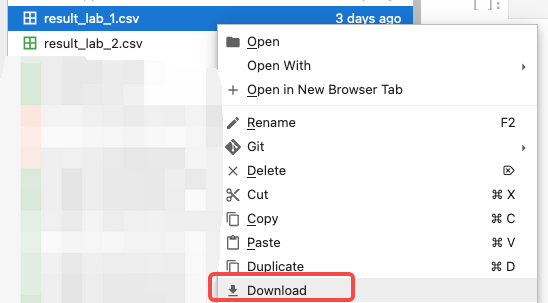